In [1]:
#Boiler Plate

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

#select one of the devices, note GPU (Nvidia or Metal) slower than CPU atm

#cpu
device = torch.device("cpu")

#nvidia cuda
#device = torch.device("cuda")

#high-performance training on Metal GPU for Mac - https://pytorch.org/docs/stable/notes/mps.html
#device = torch.device("mps")
#%env PYTORCH_ENABLE_MPS_FALLBACK=0

#words(names) loaded
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)} 
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [7]:
#parameters of NN

vocab_size = len(itos) #vocabulary size - all letter and start/end character (.)

block_size = 3 #context length: how many characters do we take to predict the next one
n_embd = 10 #dimensionalityof the character embedding vectors
n_hidden = 200 #number of neurons in the hidden layer of the MLP

max_steps = 200000 #no steps for training
batch_size = 32 #minibatch size

In [3]:
#build dataset
def build_dataset(words):
    X, Y = [], []
    
    for w in words:
    
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] #crop and append
    
    X = torch.tensor(X, device=device)
    Y = torch.tensor(Y, device=device)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# training split, dev/validation split, test split
# 80%, 10%, 10%
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [83]:
g = torch.Generator().manual_seed(2147483647) #deterministic reproducibility
C = torch.randn((vocab_size,n_embd),                generator=g).to(device) 

# fix tanh layer too saturated at init by manual factoring
W1 = torch.randn((n_embd * block_size, n_hidden),   generator=g).to(device) * 0.2 #to combat -1 and 1 concentration for 1
b1 = torch.randn(n_hidden,                          generator=g).to(device) * 0.01 #same as above

# fix softmax confidently wrong by manual factoring
W2 = torch.randn((n_hidden, vocab_size),            generator=g).to(device) * 0.01 #to combat initial high loss, which should be -log(1/27)=3.2958.
b2 = torch.randn(vocab_size,                        generator=g).to(device) * 0 #to combat initial high loss
#Note W2 * 0 will result in a initial loss of 3.2958, that but it is problematic.

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
        p.requires_grad = True


11897


In [84]:
lossi = []

pp = 0
for i in range(max_steps):

    #minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g, device=device)
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X, Y

    #forward pass
    emb = C[Xb] #embed the characters in vectors
    embcat = emb.view(emb.shape[0], -1) #concatanate the vectors
    hpreact = embcat @ W1 + b1 #hidden layer pre-activation
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 #output layer
    loss = F.cross_entropy(logits, Ytr[ix]) #loss function

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    #print progress
    currentStep = i + 1
    totalNoSteps = max_steps
    currentProgress = int(float(currentStep) / float(totalNoSteps) *100)
    reportingStep = 2
    if (currentStep > pp) and (currentProgress % reportingStep == 0):
        progress = "Progressed " + str(currentProgress) + "%" + " at Step " + str(currentStep) + " of " + str(totalNoSteps) + " with loss " + f'{loss.item():.4f}'
        print(progress, end="\r")
        pp = currentStep + (totalNoSteps / 100) - reportingStep #cut-off until next step

    #track stats
    lossi.append(loss.log10().item())

    #break #to see initial loss

(array([143., 172., 172., 161., 142., 151., 133., 116., 116., 143.,  95.,
        104., 126., 111., 119.,  91.,  86.,  90., 115., 100., 112., 122.,
        111.,  77., 103., 119., 100., 106.,  91.,  90., 117., 114., 116.,
        115., 107., 131., 111., 109., 114., 118., 142., 127., 162., 169.,
        152., 197., 184., 192., 208., 198.]),
 array([-9.98924255e-01, -9.58988956e-01, -9.19053657e-01, -8.79118358e-01,
        -8.39183059e-01, -7.99247760e-01, -7.59312460e-01, -7.19377161e-01,
        -6.79441862e-01, -6.39506563e-01, -5.99571264e-01, -5.59635965e-01,
        -5.19700665e-01, -4.79765366e-01, -4.39830067e-01, -3.99894768e-01,
        -3.59959469e-01, -3.20024170e-01, -2.80088871e-01, -2.40153571e-01,
        -2.00218272e-01, -1.60282973e-01, -1.20347674e-01, -8.04123747e-02,
        -4.04770756e-02, -5.41776419e-04,  3.93935227e-02,  7.93288219e-02,
         1.19264121e-01,  1.59199420e-01,  1.99134719e-01,  2.39070019e-01,
         2.79005318e-01,  3.18940617e-01,  3.58875

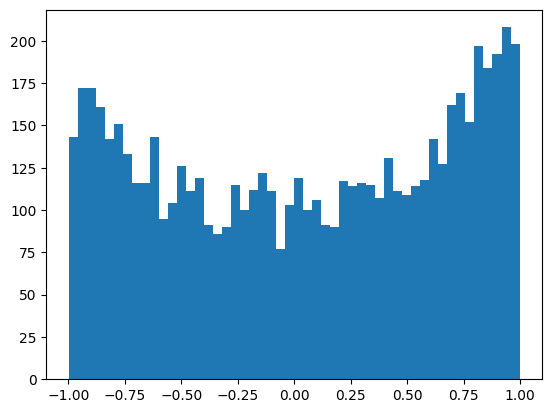

In [80]:
plt.hist(h.view(-1).tolist(),50) #without adjustmens on W1 and B1, this was resulting in concentration of -1 and 1 values

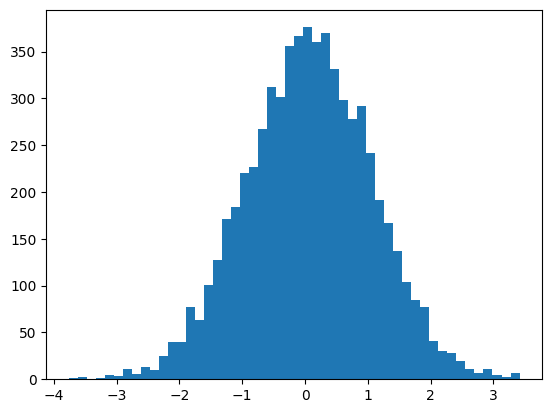

In [81]:
plt.hist(hpreact.view(-1).tolist(),50); #without adjustmens on W1 and B1, too large spread here causing above mentioned -1 and 1 concentration of h

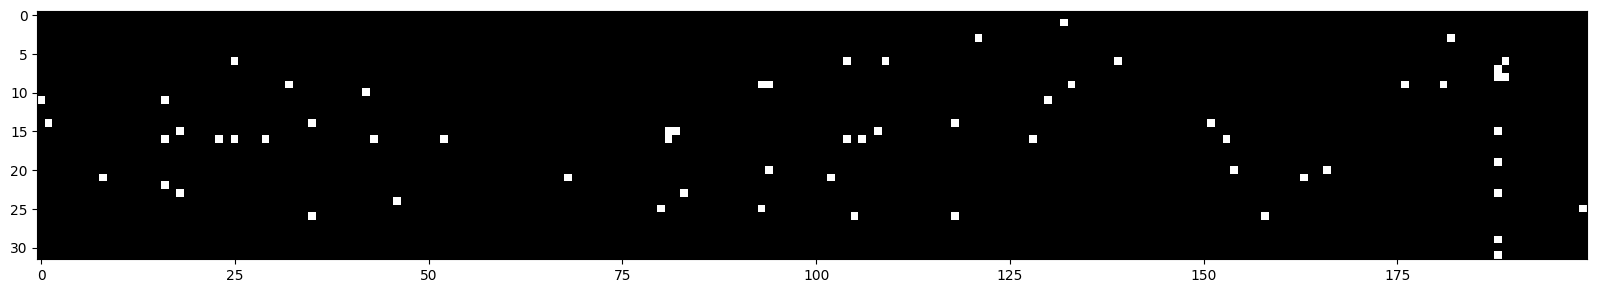

In [82]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest') #how often h is in the flat region >0.99 resulting in 0*grad in backprop, white dots show TRUE
#if a column is all white, this is a dead neuron since it can never be activated during backprop
#before adjustments on W1 and b1, this was resulting in many white dots and potentially dead neurons during init or training

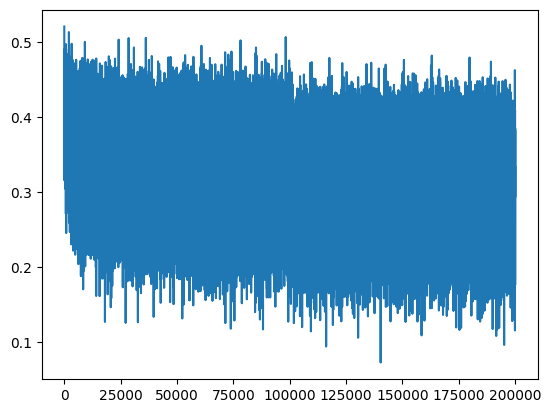

In [85]:
plt.plot(lossi) #no more hockey stick due to high initial loss

In [86]:
@torch.no_grad() #this decorator disables gradient tracking for below function - efficiency since no backward pass
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] #(N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) #concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)  
    logits = h @ W2 + b2 # (N. vocab_size)
    loss = F.cross_entropy(logits, y) #loss function
    #print(split, loss.item())
    return loss

lossT = split_loss('train')
lossD = split_loss('val')
lossAll = "Losses @ Training & Validation Sets: " + f'{lossT.item():.4f}' + " & " +  f'{lossD.item():.4f}'
print(lossAll)

Losses @ Training & Validation Sets: 2.0356 & 2.1027


In [87]:
#sampling

#sample 10 time for maximum quality
bestquality = 0.0
bestgenwords = ""
bestcountexct = 0

for rand in range(11):
    g = torch.Generator().manual_seed(2147483647+rand)

    generation = []
    numberofgen = 20
    for i in range(numberofgen):

        out = []
        context = [0] * block_size #start with dot
        while True:
            emb = C[torch.tensor([context])] # (1, block_size, d)
            h = torch.tanh(emb.view(1, -1) @ W1 + b1)
            logits = h @ W2 + b2
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:
                break

        generated = ''.join(itos[i] for i in out).rstrip(".")
        generation.append(generated) 

    #find the words which already existed in the training set
    genwords = ""
    countexct = 0
    #c = [0 for x in range(0, len(generation))] #just marking the index
    for i, x in enumerate(generation):
        if len(genwords) > 0:
            genwords += ", "

        genwords += x

        if x in words[:n1]:
            #c[i] = 1
            countexct += 1
            genwords += "+"

    quality = (100*(1.0 - float(countexct)/float(numberofgen)))

    if quality > bestquality:
        bestgenwords = genwords
        bestcountexct = countexct
        bestquality = quality

bestcount = str(bestcountexct) + " no. (+ marked) generated words are exact copies from the training set; uniqueness score " + str(numberofgen-bestcountexct) + "/" + str(numberofgen) + ", " + f'{bestquality:.0f}' + "%."

#Markdown output
from IPython.display import display, Markdown, Latex
output = """\
Below setup with `{parameters}`no. parameters, results in Losses of ~`{lossT}` for training / ~`{lossD}` for dev/validation data sets:

`block_size = {block_size} | n_embd = {n_embd} | n_hidden = {n_hidden} | batch_size = {batch_size} | max_steps = {max_steps}`

>`block_size` is the context length; how many characters do we take to predict the next one),<br>
>`n_embd` is the dimensionality of the character embedding vectors,<br>
>`n_hidden` number of neurons in the hidden layer of the MLP,<br>
>`batch_size` is minibatch size,<br>
>`max_steps` is number steps in each loop for gradient descent

Generated words with Uniqueness Score of **~{bestquality}%** and other stats as follows:

| First Run|
|---|
| {bestgen1} |
| {bestcount1} |
| {loss1} |
<hr/>
""".format(
    parameters=sum(p.nelement() for p in parameters),
    lossT=f'{lossT:.4f}',
    lossD=f'{lossD:.4f}',
    block_size = block_size,
    n_embd = n_embd,
    n_hidden = n_hidden,
    batch_size = batch_size,
    max_steps = max_steps, 
    bestquality = f'{bestquality:.0f}',
    bestgen1 = bestgenwords,
    bestcount1 = bestcount,
    loss1 = lossAll,
)
display(Markdown(output))

#minute mark 27:53

Below setup with `11897`no. parameters, results in Losses of ~`2.0356` for training / ~`2.1027` for dev/validation data sets:

`block_size = 3 | n_embd = 10 | n_hidden = 200 | batch_size = 32 | max_steps = 200000`

>`block_size` is the context length; how many characters do we take to predict the next one),<br>
>`n_embd` is the dimensionality of the character embedding vectors,<br>
>`n_hidden` number of neurons in the hidden layer of the MLP,<br>
>`batch_size` is minibatch size,<br>
>`max_steps` is number steps in each loop for gradient descent

Generated words with Uniqueness Score of **~95%** and other stats as follows:

| First Run|
|---|
| dex, mariah, makilah, tyhammonie, traine, kayk, kata, kreez, pebutharminton, moriella, kinzleed, akareedensedey, niavion, rosbur, hunaven, tahiro, kaspe, breen, hayah, isa+ |
| 1 no. (+ marked) generated words are exact copies from the training set; uniqueness score 19/20, 95%. |
| Losses @ Training & Validation Sets: 2.0356 & 2.1027 |
<hr/>
